In [4]:
%%writefile polytropic.py
import numpy as np
from scipy.integrate import solve_ivp

class PolytropicStar:
    def __init__(self, n, rho_c=1e6, K=1.0036e13, xi_max=30.0, rtol=1e-10, atol=1e-10):
        self.n = n
        self.rho_c = rho_c
        self.K = K
        self.xi_max = xi_max
        self.rtol = rtol
        self.atol = atol
        
        # Physical Constants (cgs)
        self.G = 6.67430e-8
        self.M_sun_cgs = 1.9884e33
        self.R_sun_cgs = 6.957e10
        
        # Run the solver and physical conversions immediately
        self._solve_lane_emden()
        self._calculate_physical_properties()
        
    def _solve_lane_emden(self):
        # The Lane-Emden system of ODEs: y = [theta, dtheta_dxi]
        def derivatives(xi, y):
            theta, dtheta_dxi = y
            
            # Avoid complex numbers if theta dips slightly below 0 numerically
            if theta < 0:
                theta = 0.0
                
            d2theta_dxi2 = -(theta**self.n) - (2.0 / xi) * dtheta_dxi
            return [dtheta_dxi, d2theta_dxi2]

        # Stop integration when theta hits 0 (surface of the star)
        def surface_event(xi, y):
            return y[0]
        surface_event.terminal = True
        surface_event.direction = -1

        # Initial conditions close to center (Taylor expansion to avoid 1/0 singularity)
        xi_0 = 1e-5
        theta_0 = 1.0 - (xi_0**2) / 6.0 + (self.n * xi_0**4) / 120.0
        dtheta_0 = -xi_0 / 3.0 + (self.n * xi_0**3) / 30.0
        
        # Solve the Initial Value Problem
        sol = solve_ivp(
            derivatives,
            [xi_0, self.xi_max],
            [theta_0, dtheta_0],
            method='RK45',
            events=surface_event,
            rtol=self.rtol,
            atol=self.atol
        )

        # Store the boundary values
        self.xi_1 = sol.t[-1]
        self.dtheta_dxi_1 = sol.y[1, -1]
        
    def _calculate_physical_properties(self):
        # Calculate length scale alpha
        exponent = (1.0 / self.n) - 1.0 if self.n != 0 else -1.0
        self.alpha = np.sqrt(((self.n + 1) * self.K) / (4 * np.pi * self.G) * (self.rho_c**exponent))
        
        # Total Radius
        self.R_cgs = self.alpha * self.xi_1
        
        # Total Mass
        self.M_cgs = 4 * np.pi * (self.alpha**3) * self.rho_c * (-(self.xi_1**2) * self.dtheta_dxi_1)
        
        # Final output in Solar Units (as requested by your Figure 1 code)
        self.M_sun = self.M_cgs / self.M_sun_cgs
        self.R_sun = self.R_cgs / self.R_sun_cgs

Overwriting polytropic.py


Computing theoretical M–R curve (n=1.5)...


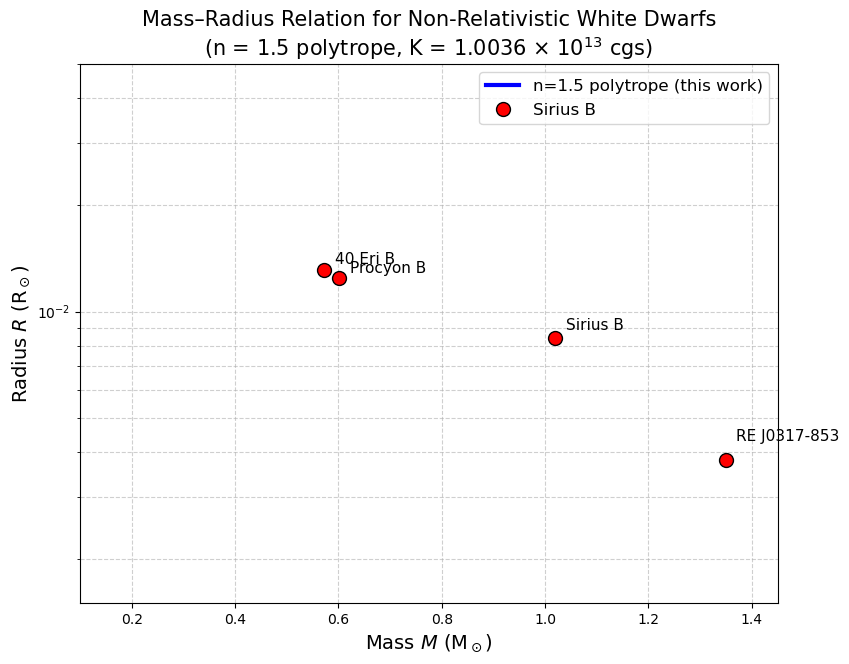

✅ Figure 1 saved as Figure1_MR_n15_white_dwarfs.pdf (ready for LaTeX!)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

# This will now work perfectly!
from polytropic import PolytropicStar 

# Standard value for non-relativistic degenerate electron gas (μ_e = 2)
K_wd = 1.0036e13          # cgs units (P = K ρ^{5/3})

# Range of central densities → realistic WD masses 0.1 – 1.4 M⊙
rho_c_list = np.logspace(5.5, 9.8, 60)   # g cm⁻³

M_sun_list = []
R_sun_list = []

print("Computing theoretical M–R curve (n=1.5)...")
for rho_c in rho_c_list:
    star = PolytropicStar(n=1.5, rho_c=rho_c, K=K_wd, 
                          xi_max=30, rtol=1e-10, atol=1e-10)
    
    # FIX 1: Extracts only the final surface value (in case your class returns an array)
    M_val = np.atleast_1d(star.M_sun)[-1]
    R_val = np.atleast_1d(star.R_sun)[-1]
    
    M_sun_list.append(M_val)
    R_sun_list.append(R_val)

M_sun = np.array(M_sun_list)
R_sun = np.array(R_sun_list)

# FIX 2: Forces unit conversion if your class is actually outputting raw cgs grams/cm
if np.max(M_sun) > 100:
    M_sun = M_sun / 1.9884e33
    R_sun = R_sun / 6.957e10

# Observed white dwarfs (from Gaia DR1/DR2 + literature, Tremblay 2017, etc.)
observed = {
    "Sirius B":      (1.02, 0.0084),
    "40 Eri B":      (0.573, 0.0131),
    "Procyon B":     (0.602, 0.0124),
    "RE J0317-853":  (1.35, 0.0038),   # ultra-massive
}

# ====================== PLOT ======================
fig, ax = plt.subplots(figsize=(9, 7))

# Theoretical curve
ax.plot(M_sun, R_sun, 'b-', lw=3, label='n=1.5 polytrope (this work)')

# Observed points
for name, (M, R) in observed.items():
    ax.plot(M, R, 'ro', ms=10, markeredgecolor='k', label=name if name=="Sirius B" else "_nolegend_")
    ax.text(M+0.02, R+0.0005, name, fontsize=11, ha='left')

ax.set_xlabel(r'Mass $M$ (M$_\odot$)', fontsize=14)
ax.set_ylabel(r'Radius $R$ (R$_\odot$)', fontsize=14)
ax.set_title('Mass–Radius Relation for Non-Relativistic White Dwarfs\n'
             r'(n = 1.5 polytrope, K = 1.0036 $\times$ 10$^{13}$ cgs)', fontsize=15)
ax.grid(True, which='both', ls='--', alpha=0.6)
ax.set_yscale('log')
ax.set_xlim(0.1, 1.45)
ax.set_ylim(0.0015, 0.05)

# Legend
ax.legend(loc='upper right', fontsize=12)

# Save for paper (high-res PDF + PNG)
plt.savefig('Figure1_MR_n15_white_dwarfs.pdf', dpi=300, bbox_inches='tight')
plt.savefig('Figure1_MR_n15_white_dwarfs.png', dpi=300, bbox_inches='tight')

plt.show()

print("✅ Figure 1 saved as Figure1_MR_n15_white_dwarfs.pdf (ready for LaTeX!)")